# FS20C8 -(Social) Media Analytics für Sportwetten
# Eugen Cuic



In [1]:
#import http.client
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import matplotlib.animation as animation
import seaborn as sns; sns.set()
import datetime as dt
from sqlalchemy.sql import text
from pandas.io.json import json_normalize
from scipy.special import factorial
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from bs4 import BeautifulSoup as bs
from tabulate import tabulate


Bad key "text.kerning_factor" on line 4 in
C:\Users\M0268176\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Agenda

In order to create a full system from data to betting it is important to have a path to go. The work will contain following steps:

- Data Ressource
    - Match Data
    - Betting Data

- API and Data
    - API Connection (**WDB**)
    - Fetch Data (**WDB**)
    - Format JSON into readable output (**DAW**)
    - Normalizing JSON and create a Pandas DataFrame (**DAW**)
    - Checking the different columns that are available (**DAW**)
    - Define final data structure (**DAW**)
    - Split the data into train and test sets (**WER, DAW**)

- Database
    - Database Logic (**DDI**)
    - Create URI and connection (**DDI**)
    - Creation of Database tables (**DDI**)
    - Prefill of data into Database (**DDI**)

- Calculate statistical values and analyse them
    - Get the unique values of team ids (**EDA**)
    - Get the home and away matches data for a specific team (**EDA**)
    - Calculate lambda for home matches (**WER**)
    - Plot histogramm of goals per match, expected value of goals and poission density function (**EDA**)
    - Automate Lambda Calculation (**DAW, WER**)
    - Show all Lambda Values per Team (**EDA**)
    - Findings(**EDA**)

- Create a performance model for probability model
    - Testsimulation (**DAW, WER**)
    - Create Match prediction probability function (**DAW, WER**)
        
- Create interactive visualisation (**IVI**)

- Load past betting quotes
    - Download Data for season 2018/2019 (**WDB**)
    - Transform the betting data into usable format to compare to prior data set (**DAW**)
    - Team ID Alignment (**DAW**)

- Store History Betting Data into Database and calculate model quotes
    - Update all historical Quotes (**DAW**)
    - Update all model Quotes (**DAW**)

- Evaluation (**ALL**)
- Final Findings (**ALL**)

# Data ressource
These ressources are used as fundamental parts to build out betting model

## Match data
Consulting the website to figure out which leagues are included, one can check out following URL:

https://www.football-data.org/documentation/api

The two most interessting competitions are the German Bundesliga and the Englisch Premier League. Those two should contain most valuable data (as very popular in both countries).

In this work the focus will lie on the German Bundesliga

Code for the German Bundesliga ist: BL1

## Betting data
In order to being able to compare my own and the real betting statistics i will scrap history betting data from this website:

https://www.football-data.co.uk/germanym.php


# API and Data
In the first instance, I will set up the connection to the API. This way I will make sure that I can call it later with less issues.

## API Connection

In [2]:
myUrl= 'http://api.football-data.org/v2/'
myToken = 'e10b4cdfa26a4d4eb2a01f1bb2122595'

head = {'X-Auth-Token': '{}'.format(myToken)}

## Fetch the data

In [3]:
# testing the connection to see what the output ist
response = requests.get(myUrl + "competitions/BL1/matches?season=2018", headers=head)

# showing the whole output would be too much for the notebook, if someone wants to see it just remove the # from the next line
#response.json()

As we can see above in the comented out line, the request is giving us all necessary data for the probability model:
- Matchday
- Team Names for Home Team
- Team Names for Away Team
- Goals for Home Team
- Goals for Away Team

And if we want to have another season we just adapt the request for the REST API
### !!WARNING!! (the free version of the API does not give more data then the season from 2018/2019)

## Format JSON into readable output
The responses from the API contain a lot more data than we need for our model. This is the reason to figure out how we can extract all the necessary data and in a format that we could use later.
In the first step we will print out all matches, ordered by the matchday, and add the respective results to see what the way to go is, in order to extract the data

In [4]:
# iterrating through all JSON responses to extract the necessary data and also format it properly
for c in response.json()['matches']:
    print ("Matchday " + str(c['matchday']) + ": " + 
    c['homeTeam']['name'] + " - " + c['awayTeam']['name'] 
    + ": Result " + str(c['score']['fullTime']['homeTeam']) + " - " 
    + str(c['score']['fullTime']['awayTeam'] ) )

Matchday 1: FC Bayern München - TSG 1899 Hoffenheim: Result 3 - 1
Matchday 1: SV Werder Bremen - Hannover 96: Result 1 - 1
Matchday 1: Hertha BSC - 1. FC Nürnberg: Result 1 - 0
Matchday 1: TSV Fortuna 95 Düsseldorf - FC Augsburg: Result 1 - 2
Matchday 1: SC Freiburg - Eintracht Frankfurt: Result 0 - 2
Matchday 1: VfL Wolfsburg - FC Schalke 04: Result 2 - 1
Matchday 1: Borussia Mönchengladbach - Bayer 04 Leverkusen: Result 2 - 0
Matchday 1: 1. FSV Mainz 05 - VfB Stuttgart: Result 1 - 0
Matchday 1: BV Borussia 09 Dortmund - RB Leipzig: Result 4 - 1
Matchday 2: Hannover 96 - BV Borussia 09 Dortmund: Result 0 - 0
Matchday 2: Eintracht Frankfurt - SV Werder Bremen: Result 1 - 2
Matchday 2: 1. FC Nürnberg - 1. FSV Mainz 05: Result 1 - 1
Matchday 2: Bayer 04 Leverkusen - VfL Wolfsburg: Result 1 - 3
Matchday 2: TSG 1899 Hoffenheim - SC Freiburg: Result 3 - 1
Matchday 2: FC Augsburg - Borussia Mönchengladbach: Result 1 - 1
Matchday 2: VfB Stuttgart - FC Bayern München: Result 0 - 3
Matchday 2: 

As seen above it is neccessary to transform the integers into strings before being able to put them into one line with the other extracted data fragments.
Extracting those values separatelly is not an issue, but it is not possible to concatenate strings and integers together.

Before splitting the data, it will be put into a Pandas DataFrame to make it easier to work with, especially because the data is still in JSON Format which makes it hard to work with when it comes to statistical models

## Normalizing JSON and create a Pandas DataFrame

In [5]:
raw_data = response.json()
data = json_normalize(raw_data['matches'])
data.head()

,id,utcDate,status,matchday,stage,group,lastUpdated,referees,season.id,season.startDate,...,score.halfTime.homeTeam,score.halfTime.awayTeam,score.extraTime.homeTeam,score.extraTime.awayTeam,score.penalties.homeTeam,score.penalties.awayTeam,homeTeam.id,homeTeam.name,awayTeam.id,awayTeam.name
0,235686,2018-08-24T18:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 15746, 'name': 'Bastian Dankert', 'nat...",155,2018-08-24,...,1,0,None,None,None,None,5,FC Bayern München,2,TSG 1899 Hoffenheim
1,235688,2018-08-25T13:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 43875, 'name': 'Felix Brych', 'nationa...",155,2018-08-24,...,0,0,None,None,None,None,12,SV Werder Bremen,8,Hannover 96
2,235689,2018-08-25T13:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 57539, 'name': 'Tobias Welz', 'nationa...",155,2018-08-24,...,1,0,None,None,None,None,9,Hertha BSC,14,1. FC Nürnberg
3,235691,2018-08-25T13:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 174, 'name': 'Markus Schmidt', 'nation...",155,2018-08-24,...,1,0,None,None,None,None,24,TSV Fortuna 95 Düsseldorf,16,FC Augsburg
4,235692,2018-08-25T13:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 57510, 'name': 'Manuel Gräfe', 'nation...",155,2018-08-24,...,0,1,None,None,None,None,17,SC Freiburg,19,Eintracht Frankfurt


It was possible to put the data into the DataFrame and format it correctly, so far an possible optimization would be to see if it would be possible to put the data into the DataFrame directly after the extration some steps earlier.

As the DataFrame is becoming very big and it is not easy to see what the different column names are in the frame. It woudld also make sense to list all names to filter wich ones are necessary. 

## Checking the different columns that are available

In [6]:
for col in data.columns: 
    print(col) 

id
utcDate
status
matchday
stage
group
lastUpdated
referees
season.id
season.startDate
season.endDate
season.currentMatchday
odds.msg
score.winner
score.duration
score.fullTime.homeTeam
score.fullTime.awayTeam
score.halfTime.homeTeam
score.halfTime.awayTeam
score.extraTime.homeTeam
score.extraTime.awayTeam
score.penalties.homeTeam
score.penalties.awayTeam
homeTeam.id
homeTeam.name
awayTeam.id
awayTeam.name


This overview of the column names makes it a lot easier to define which ones would make sense to add for the probability model. Bellow the columns that I will keep:

- ID: For further information, statistics etc. about a specific match it is necessary to now the ID
- Date: It would make sense to keep the Date to have a dataset to order the data by
- score.fullTime.homeTeam: The result after fullTime is the most important number for the probability model
- score.fullTime.awayTeam: The result after fullTime is the most important number for the probability model
- homeTeam.id: The id is a shortcut to faster iterrate, find, select the teams across a season
- awayTeam.id: The id is a shortcut to faster iterrate, find, select the teams across a season
- homeTeam.name: The name is necessary to match id
- awayTeam.name: The name is necessary to match id  

## Define final data structure

In [7]:
# Define the header of the DataFrame 
header = ['id', 'utcDate', 'score.fullTime.homeTeam', 'score.fullTime.awayTeam', 'homeTeam.id', 'awayTeam.id', 'homeTeam.name', 'awayTeam.name']
data_BL1_18_19 = pd.DataFrame(data, columns=header)

# Rename the columns to make it more understandable fo readers
data_BL1_18_19 = data_BL1_18_19.rename(columns={
    'id': 'match_id',
    'utcDate' : 'date',
    'score.fullTime.homeTeam': 'goals_home',
    'score.fullTime.awayTeam': 'goals_away',
    'homeTeam.id': 'home_id',
    'awayTeam.id': 'away_id',
    'homeTeam.name': 'home_name',
    'awayTeam.name': 'away_name'
    })

Before adding the data to the Database it is important to transform the date into a form that is usable. In order to do so in the first step the column Date will be transformed from object to datetime and then in the second step the datetime will be stripped to keep only the date, without the time

In [8]:
# Transform to datetime object
data_BL1_18_19['date'] = pd.to_datetime(data_BL1_18_19['date'])

In [9]:
# Strip the time
data_BL1_18_19['date'] = data_BL1_18_19['date'].dt.date

In [10]:
data_BL1_18_19.head(2)

,match_id,date,goals_home,goals_away,home_id,away_id,home_name,away_name
0,235686,2018-08-24,3,1,5,2,FC Bayern München,TSG 1899 Hoffenheim
1,235688,2018-08-25,1,1,12,8,SV Werder Bremen,Hannover 96


## Split the data into train and test set

In [11]:
# create copy to work with
data_BL1_18_19_copy = data_BL1_18_19.copy()
data_BL1_18_19_copy.set_index('match_id')

# using only 10% of random games for the test split
train_set = data_BL1_18_19_copy.sample(frac=0.9, random_state=0)
test_set  = data_BL1_18_19_copy.drop(train_set.index)

In [12]:
# Setting match_id as index
test_set = test_set.set_index('match_id')
train_set = train_set.set_index('match_id')

In [13]:
train_set.head(2)

,date,goals_home,goals_away,home_id,away_id,home_name,away_name
match_id,,,,,,,
235961,2019-04-27,4,1,24,12,TSV Fortuna 95 Düsseldorf,SV Werder Bremen
235755,2018-10-20,2,2,3,8,Bayer 04 Leverkusen,Hannover 96


# Database
## Database Logic
In order to calculate all possible scenarios, betting rates and models the SQL DB needs:

- A table with all matches and results from season 2018/2019 (without the test data)
- A table with statistical factors to calculate probabilitie
- A table with the test data to check betting forecast against

## Create URI and Connection

In [14]:
database_username ='sport'
database_password = 'sport_fhnw_20'
database_ip = '45.32.156.57'
database_port = '3306'
database_name = 'sportwetten'

database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

In [15]:
con = database_connection.connect()

## Creation of Database tables
Those commands bellow should only be used one time. Trying to execute them a 2nd time will result in an error. 
### !!!PLEASE DO NOT EXECUTE THEM AGAIN!!!

The first table to create in the schema is the one for the raw data, that we have seen before. The match ID is the unique number of every match and will also be used as primary key for this table. 

The data that will be stores in this seciton is the train data to set the statistical values

In [16]:
query = text("""
CREATE TABLE `sportwetten`.`match_data` (
  `match_id` INT NOT NULL,
  `date` DATETIME NOT NULL,
  `goals_home` INT NOT NULL,
  `goals_away` INT NOT NULL,
  `home_id` INT NOT NULL,
  `away_id` INT NOT NULL,
  `home_name` VARCHAR(45) NOT NULL,
  `away_name` VARCHAR(45) NOT NULL,
  PRIMARY KEY (`match_id`),
  UNIQUE INDEX `match_id_UNIQUE` (`match_id` ASC))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8;
""")

In [17]:
#Execute Query to create Table in DataBase
con.execute(query)

The 2nd table is used to store all statistical values for the probability functions. Every team with ID and name will be store and additionaly the statistical value "lambda" to create the Poission distributions. Furthermore I will add a column with the information if the statistics is for away or at home as the statistics will slightly be different.

In [18]:
query = text("""
CREATE TABLE `sportwetten`.`team_statistics` (
  `team_id` INT NOT NULL,
  `team_name` VARCHAR(45) NOT NULL,
  `lambda_home` FLOAT NULL,
  `lambda_away` FLOAT NULL,
  PRIMARY KEY (`team_id`))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8;
""")

In [19]:
#Execute Query to create Table in DataBase
con.execute(query)

The 3rd table will contain the test data. In this table the forecast will happen. It will look the same as the 1st table with the raw train data, just with additional columns to put in the betting quotes for the match (predicted and real)

In [20]:
query = text("""
CREATE TABLE `sportwetten`.`betting_data` (
  `match_id` INT NOT NULL,
  `date` DATETIME NOT NULL,
  `goals_home` INT NOT NULL,
  `goals_away` INT NOT NULL,
  `home_id` INT NOT NULL,
  `away_id` INT NOT NULL,
  `home_name` VARCHAR(45) NOT NULL,
  `away_name` VARCHAR(45) NOT NULL,
  `home_victory_pred` FLOAT NULL,
  `away_victory_pred` FLOAT NULL,
  `draw_pred` FLOAT NULL,
  `home_victory_real` FLOAT NULL,
  `away_victory_real` FLOAT NULL,
  `draw_real` FLOAT NULL)
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8;
""")

In [21]:
#Execute Query to create Table in DataBase
con.execute(query)

## Prefill of data into Database

In [22]:
# Prefill data that is availabe
train_set.to_sql(con=con, name='match_data', if_exists='append')

test_set.to_sql(con=con, name='betting_data', if_exists='append')

In [23]:
# Select only two columns of DF
data = data_BL1_18_19_copy[['home_id', 'home_name']]
data = data.rename(columns={
    'home_id': 'team_id',
    'home_name': 'team_name',
    })

# Drop duplicates
data = data.drop_duplicates()

# Set team_id as index (primary key)
data = data.set_index('team_id')

In [24]:
data.to_sql(con=con, name='team_statistics', if_exists='append')

# Calculate statistical values and analyse them

In the next step it is necessary to define what kind of probability distribution I should choose. There are two different kinds of random values of a distribution. A continuous and a discrete random variable. 

In the case of goals of a match, we have a discrete random variable and for such variables we are looking to find a distribution that gives every value a probability. In this case we are looking for a probability function. Possible probability functions are:

- Bernoulli distribution
- Binomial distribution
- Poisson distribution

As Bernoulli and Binomial distributions need probabilities for either success or fialure we need to drop those distributions as we don't have them. The Poisson distribution is regularly used when the attempts are high and the amounts of sucessful atempts low. In the case of football we have a lot ot atempts in a match (atempts to score a goal) but only a few succesfull ones (goals in a match).

In this section I will perform the calculation of lambda for every team based on the train set for home and away situations as those will be different (teams are differently motivated by the fans at home and away)

## Get the unique values of team ids

In [25]:
unique_team_ids = train_set['home_id'].unique()
print(unique_team_ids)

[ 24   3   2  14 721  15  12  11   6  10  19   5  17  16   8  18   9   4]


## Get the home and away matches data for a specific team

In [26]:
home_matches = train_set.loc[(train_set['home_id'] == 17)]
home_matches.head(2)

,date,goals_home,goals_away,home_id,away_id,home_name,away_name
match_id,,,,,,,
235709,2018-09-16,3,3,17,10,SC Freiburg,VfB Stuttgart
235790,2018-11-25,1,1,17,12,SC Freiburg,SV Werder Bremen


## Get all the away match data for a specific team

In [27]:
away_matches = train_set.loc[(train_set['away_id'] == 17)]
away_matches.head(2)

,date,goals_home,goals_away,home_id,away_id,home_name,away_name
match_id,,,,,,,
235978,2019-05-11,3,0,8,17,Hannover 96,SC Freiburg
235839,2019-01-19,3,1,19,17,Eintracht Frankfurt,SC Freiburg


## Calculate lambda for home matches
The only statistical value that is needed for a Poission distribution is lambda. In order to calculate lambda we will assume that the expected value of goals is lambda (based on the theorie of the Poission distribution)

In [28]:
lambda_home = home_matches['goals_home'].sum() / len(home_matches['goals_home'])
print(lambda_home)

1.8571428571428572


## Plot histogramm of goals per match, expected value of goals and poission density function

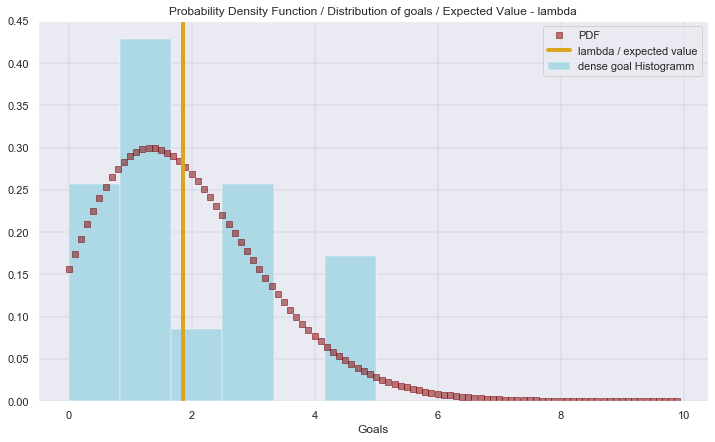

In [29]:
plt.figure(figsize=(12,7)) 

# Plot histogram of goals
plt.hist(home_matches['goals_home'], 
         bins=6, density=True, 
         histtype='bar', color='lightblue',
         edgecolor='white', linewidth=0.4,
         label='dense goal Histogramm')

# Create Poission distriution for calculated lambda value
t = np.arange(0, 10, 0.1)
d = np.exp(-lambda_home)*np.power(lambda_home, t)/factorial(t)
plt.plot(t, d, 'bs', color='maroon', alpha=0.5, label='PDF')

# Plot lambda value as vertical line
plt.axvline(x=lambda_home, color='goldenrod', lw=4, label='lambda / expected value')

# Visuals
plt.title("Probability Density Function / Distribution of goals / Expected Value - lambda")
#plt.ylabel("Number of Games")
plt.xlabel("Goals") 
plt.legend(loc='upper right')
plt.grid(color='black', linestyle='-', linewidth=0.25, alpha=0.3)

plt.show()

## Automate Lambda Calculation

In [30]:
def calculate_lambda(team_id):
    # Get all the home match data for a specific team
    home_matches = train_set.loc[(train_set['home_id'] == team_id)]

    # Get all the away match data for a specific team
    away_matches = train_set.loc[(train_set['away_id'] == team_id)]

    lambda_home = home_matches['goals_home'].sum() / len(home_matches['goals_home'])

    lambda_away = away_matches['goals_away'].sum() / len(away_matches['goals_away'])
    
    lambda_h = ("UPDATE `team_statistics` SET `lambda_home` = {} WHERE `team_id` = {};").format(lambda_home, team_id)
    lambda_a = ("UPDATE `team_statistics` SET `lambda_away` = {} WHERE `team_id` = {};").format(lambda_away, team_id)

    con.execute(lambda_h)
    con.execute(lambda_a)

In [31]:
# Calculating for all teams the lambda for home and away and store it in the table "team_statistics"
for team_id in unique_team_ids:
    calculate_lambda(team_id)

## Show all Lambda Values per Team

In [32]:
all_lambda = pd.read_sql_table('team_statistics', con=con)
all_lambda

,team_id,team_name,lambda_home,lambda_away
0,2,TSG 1899 Hoffenheim,1.60000,2.400000
1,3,Bayer 04 Leverkusen,1.93333,2.176470
2,4,BV Borussia 09 Dortmund,3.05882,2.000000
3,5,FC Bayern München,2.88235,2.437500
4,6,FC Schalke 04,1.00000,1.333330
5,8,Hannover 96,1.00000,1.000000
6,9,Hertha BSC,1.76923,1.187500
7,10,VfB Stuttgart,1.31250,0.666667
8,11,VfL Wolfsburg,2.06250,1.357140
9,12,SV Werder Bremen,2.06667,1.375000


## Findings
Due to the lack of available data (Corona Virus) the error rate of the function might be too high. We see that that fit is somehow "ok-ish". If there would be more data the function would also be more accurate. As the goal of this challenge is NOT to have a perfect betting system, instead of that, just to figure out how it could work, I will continue with this approach. As I follow the rule to not repeat myself I will construct a function to extract the lambda values for each team in an easy manner.

As it is visible we have for every team different performances for matches at home and matches away. Also teams like FC Bayern München have quite a high performance compared to a team like SC Freiburg. Those two teams are most of the season somewhere at the top (FC Bayern München) respectively in the lower range (SC Freiburg). This indicates that the performance measure might actually work out

# Create a performance model for probability model
In order to calculate the outcome of a match between two teams I will let both teams play virtually a couple of tousand times to see how many times each team will winn or how many times we will see a draw. In order to do so I will proceed with following steps:
- Check which team is playing at home and away
- Load the respective lambdas for each team
- Perform a Monte Carlo Simulation several tousand times with a Poission distribution
- --> The Poission distribution will calculate how many goals each team will socre
- --> The goals are rounded to integers
- Evaulate the results:
- --> The team with more goals will win
- --> The team with less goals will lose
- --> If both teams have same amount of goals, it's a draw

## Testsimulation
Before creating the function, I will build it step by step with some pre defined examples

In [40]:
# Fetching lambda values for home and away team
team_id_home = 4
data = 'SELECT lambda_home FROM sportwetten.team_statistics WHERE team_id = %i' % team_id_home
data_df = pd.read_sql(data, con=con)
lambda_home_team = data_df['lambda_home'][0]
print(lambda_home_team)

team_id_away = 14
data = 'SELECT lambda_away FROM sportwetten.team_statistics WHERE team_id = %i' % team_id_away
data_df = pd.read_sql(data, con=con)
lambda_away_team = data_df['lambda_away'][0]
print(lambda_away_team)

3.05882
0.5625


In [41]:
# Check what would be the output based on a random poission distribution
goals_home = round(np.random.poisson(lambda_home_team))
print(goals_home)

goals_away = round(np.random.poisson(lambda_away_team))
print(goals_away)

4
2


In [42]:
# Setting the counting values at zero
win_home = 0
win_away = 0
draw = 0

In [43]:
# Implement logic to count end result of matches
if goals_home > goals_away:
    win_home += 1
elif goals_home < goals_away:
    win_away += 1
else:
    draw += 1

In [44]:
# Print the counting values to see if the result machtes with counting
print(win_away)
print(win_home)
print(draw)

0
1
0


## Create Match prediction probability function

In [45]:
def match_prediction_prob (team_away_id, team_home_id, iterrations):

    # Fetch lambda value for home and away team
    data = 'SELECT lambda_home FROM sportwetten.team_statistics WHERE team_id = %i' % team_home_id
    data_df = pd.read_sql(data, con=con)
    lambda_home_team = data_df['lambda_home'][0]

    data = 'SELECT lambda_away FROM sportwetten.team_statistics WHERE team_id = %i' % team_away_id
    data_df = pd.read_sql(data, con=con)
    lambda_away_team = data_df['lambda_away'][0]

    # Setting counting values at zero
    win_home = 0
    win_away = 0
    draw = 0
    attempts = 0

    # calculate the number of steps for interactive visualisation
    steps = 10
    lenght_df = int((iterrations/steps))

    # create an empty DataFrame to be filled for interactive visualisation
    feature_list = ['matches', 'wins_home', 'wins_away', 'draws']
    df_viz = pd.DataFrame(0, index=np.arange(lenght_df), columns=feature_list)


    for n in range(iterrations):
        goals_home = np.random.poisson(lambda_home_team)
        goals_away = np.random.poisson(lambda_away_team)

        if goals_home > goals_away:
            win_home += 1
        elif goals_home < goals_away:
            win_away += 1
        else:
            draw += 1
        i = n+1

        if i % 10 == 0:
            i_int = int(i)
            step_index = int(i/steps)
            df_viz.at[i/steps, 'matches'] = i_int
            df_viz.at[i/steps, 'wins_home'] = win_home / (n+1)
            df_viz.at[i/steps, 'wins_away'] = win_away / (n+1)
            df_viz.at[i/steps, 'draws'] = draw/ (n+1)
    df_viz.matches = df_viz.matches.astype(int)
    return df_viz


In [47]:
predictions = match_prediction_prob(4,14,5000)
predictions.head(5)

,matches,wins_home,wins_away,draws
0,0,0.000,0.000000,0.000000
1,10,0.100,0.600000,0.300000
2,20,0.200,0.600000,0.200000
3,30,0.200,0.533333,0.266667
4,40,0.175,0.625000,0.200000


# Create interactive visualisation
It would be nice to see some race bars how the probabilities evolve over time (number of matches). In this chapter I am going to show you how i built the Interactive visualisation and create an mp4 video that is able to display it

As there are not many possibilities from library perspective, I had to lean heavily on the work of Ted Petrou. Following things have been done by myself:
- Adapting Data to fit into the production
- Adapt styling
- Adapt description within the visualisations

The link to the work of Ted can be found here:

https://medium.com/dunder-data/create-a-bar-chart-race-animation-in-python-with-matplotlib-477ed1590096

In [48]:
def interactive_prediction (home_id, away_id, attempts):
    # Load data with the help of the previously created function
    data = match_prediction_prob(home_id, away_id, attempts).set_index('matches')

    # Load team name
    query_home = 'SELECT team_name FROM sportwetten.team_statistics WHERE team_id = %i' % home_id
    home_team_name = pd.read_sql(query_home, con=con)
    home_team_name = home_team_name.team_name[0]

    query_away = 'SELECT team_name FROM sportwetten.team_statistics WHERE team_id = %i' % away_id
    away_team_name = pd.read_sql(query_away, con=con)
    away_team_name = away_team_name.team_name[0]

    # Get the last index of the DataFrame
    last = data.index[-1]
    data = data.reset_index()

    # Create a step to make sure every possible lenght of data can match the function
    df2 = data.loc[0:last]
    df2 = df2.reset_index()

    # Prolong the Frame to create space for intrapolation
    df2.index = df2.index * 5
    last_index = df2.index[-1] + 1
    df_expanded = df2.reindex(range(last_index))

    # Fill up the new created cells with NaN
    df_expanded['matches'] = df_expanded['matches'].fillna(method='ffill')
    df_expanded = df_expanded.set_index('matches')

    # Drop the old index columns, as this would only make a messy visualisation
    df_expanded = df_expanded.drop(columns=['index'])

    # Intrapolate linearly from one step to the next
    df_expanded = df_expanded.interpolate()

    # Create a ranking to make sure the colors remain at the same values
    df_rank_expanded = df_expanded.rank(axis=1, method='first')
    df_rank_expanded = df_rank_expanded.interpolate()

    # Define styling for the visualisation of the axles
    def nice_axes(ax):
        ax.set_facecolor('.2')
        ax.tick_params(labelsize=7, length=0)
        ax.grid(True, axis='x', color='grey')
        ax.set_axisbelow(True)
        [spine.set_visible(False) for spine in ax.spines.values()]

    # For every loop of pictures that is created the graphic must be cleared
    def init():
        ax.clear()
        nice_axes(ax)

    # Loops through all rows of DataFrame to create a "video"
    def update(i):
        for bar in ax.containers:
            bar.remove()
        y = df_rank_expanded.iloc[i]

        width = df_expanded.iloc[i]
        labels = df_expanded.columns
        ax.barh(y=y, width=width, color=colors, tick_label=labels)
        date_str = df_expanded.index[i]
        ax.tick_params(labelsize=6)
        ax.set_title('Who wins the match? Probability calculation between \n %s (Home) and %s (Away) after %i matches' % (home_team_name, away_team_name, date_str), fontsize=6)
        
    fig = plt.Figure( dpi=144)
    colors = plt.cm.tab10(range(3))
    ax = fig.add_subplot()

    # Use the animation library to put all the picutres into a slideshow which can appear as vides
    anim2 = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(df_expanded), 
                        interval=50, repeat=False)
    
    # Safe the created video
    anim2.save('%s vs %s.mp4' % (home_team_name, away_team_name))

In order to create a racebar plot, please use the function bellow. You need to put in 3 different inputs:
- 1st is the home team id
- 2nd is the away team id
- 3rd is the amount of matches that should be play against

Once the calculation is done, you can find the video in the working directory of this file with the naming: Home_Team vs Away_Team.mp4

In [49]:
# This is an example production with team 4 and 14 and 1000 matches
interactive_prediction(4,14,1000)

# Load past betting quotes
## Download Data for season 2018/2019

In [50]:
# Download the data from the website and safe into CSV File
url = requests.get('https://www.football-data.co.uk/germanym.php').text
dirs = 'mmz4281/1819/D1.csv'

soup = bs(url)
for link in soup.findAll("a"):
    current_link = link.get("href")
    if current_link.endswith((dirs)):
        response = requests.get('http://www.football-data.co.uk/%s' % current_link, stream=True)
        fn = current_link.split('/')[0] + '_' + current_link.split('/')[1] + '_' + current_link.split('/')[2]
        with open (fn, "wb") as handle:
            for data in response.iter_content():
                handle.write(data)

betting_history = pd.read_csv('mmz4281_1819_D1.csv')
betting_history.head(2)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,D1,24/08/2018,Bayern Munich,Hoffenheim,3,1,H,1,0,H,...,3.55,22,-2.0,1.92,1.87,2.05,1.99,1.23,7.15,14.10
1,D1,25/08/2018,Fortuna Dusseldorf,Augsburg,1,2,A,1,0,H,...,1.76,20,0.0,1.80,1.76,2.17,2.11,2.74,3.33,2.78


In [51]:
# Transform the Date into the same format as Date from previous data
betting_history['Date'] = pd.to_datetime(betting_history['Date'])
betting_history.head(2)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,D1,2018-08-24,Bayern Munich,Hoffenheim,3,1,H,1,0,H,...,3.55,22,-2.0,1.92,1.87,2.05,1.99,1.23,7.15,14.10
1,D1,2018-08-25,Fortuna Dusseldorf,Augsburg,1,2,A,1,0,H,...,1.76,20,0.0,1.80,1.76,2.17,2.11,2.74,3.33,2.78


### As it can be seen above, the data is full of not fully understandable columns and data. 
### In order to understand it one can check the notes which can be found here:
https://www.football-data.co.uk/notes.txt

The Data that we need is:
- Team Name in order to align Name and ID with the data we already have
- Which team is Home and which is away
- Score after Full Time
- Date in order to find the matchday
- Betting History for:
    - Win Home
    - Win Away
    - Draw

For the history data that means we will keep:

- 'Date' for the Date
- HomeTeam for home_name
- AwayTeam for away_name
- FTHG (FullTimeHomeGoal) for goals_home
- FTAG (FullTimeAwayGoal) for goals_away
- Betting History from Bet & Win:
    - BWH (Bet&Win home win odds) for home_victory_real
    - BWA (Bet&Win away win odds) for away_victory_real
    - BWD (Bet&Win draw odds) for draw_real

In [52]:
# Filter out the needed columns
betting_history = betting_history.filter(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'BWH', 'BWA', 'BWD'], axis=1)
betting_history

,Date,HomeTeam,AwayTeam,FTHG,FTAG,BWH,BWA,BWD
0,2018-08-24,Bayern Munich,Hoffenheim,3,1,1.20,11.50,7.50
1,2018-08-25,Fortuna Dusseldorf,Augsburg,1,2,2.40,3.00,3.30
2,2018-08-25,Freiburg,Ein Frankfurt,0,2,2.35,3.20,3.20
3,2018-08-25,Hertha,Nurnberg,1,0,2.05,3.70,3.40
4,2018-08-25,M'gladbach,Leverkusen,2,0,2.85,2.40,3.50
...,...,...,...,...,...,...,...,...
301,2019-05-18,Mainz,Hoffenheim,4,2,4.33,1.62,5.00
302,2019-05-18,M'gladbach,Dortmund,0,2,2.95,2.15,4.10
303,2019-05-18,Schalke 04,Stuttgart,0,0,1.62,5.00,4.33
304,2019-05-18,Werder Bremen,RB Leipzig,2,1,2.65,2.45,3.80


## Transform the betting data into usable format to compare to prior data set
In order to reuse the set the easiest way to do so is to have the same format of the date (already done) and give every team the same ID as before, as alligning the names is too much effort and comparing numbers is easier than comparing strings

In [53]:
# First rename columns for easier understanding
betting_history = betting_history.rename(columns={
    'HomeTeam': 'home_name',
    'AwayTeam': 'away_name',
    'FTHG' : 'goals_home', 
    'FTAG' : 'goals_away',
    'BWH' : 'home_victory_real',
    'BWA' : 'away_victory_real',
    'BWD' : 'draw_real',
    'Date' : 'date'
    })

# Adding columns for the IDs
betting_history['home_id'] = ''
betting_history['away_id'] = ''

betting_history.head(2)

,date,home_name,away_name,goals_home,goals_away,home_victory_real,away_victory_real,draw_real,home_id,away_id
0,2018-08-24,Bayern Munich,Hoffenheim,3,1,1.2,11.5,7.5,,
1,2018-08-25,Fortuna Dusseldorf,Augsburg,1,2,2.4,3.0,3.3,,


## Team ID Alignment
The data in regards to IDs is taken from the team_statistics table from the DataBase. The solution is not the nicest one. Hardcoding such work is not recommendet. From a coding perspective it still did make sense as the numbers are easier to compare and to align

In [54]:
# Adding Team IDs for home team
betting_history.loc[betting_history['home_name'] == 'Bayern Munich', 'home_id'] = 5
betting_history.loc[betting_history['home_name'] == 'Fortuna Dusseldorf', 'home_id'] = 24
betting_history.loc[betting_history['home_name'] == 'Freiburg', 'home_id'] = 17
betting_history.loc[betting_history['home_name'] == 'Hertha', 'home_id'] = 9
betting_history.loc[betting_history['home_name'] == "M'gladbach", 'home_id'] = 18
betting_history.loc[betting_history['home_name'] == 'Werder Bremen', 'home_id'] = 12
betting_history.loc[betting_history['home_name'] == 'Wolfsburg', 'home_id'] = 11
betting_history.loc[betting_history['home_name'] == 'Dortmund', 'home_id'] = 4
betting_history.loc[betting_history['home_name'] == 'Mainz', 'home_id'] = 15
betting_history.loc[betting_history['home_name'] == 'Hannover', 'home_id'] = 8
betting_history.loc[betting_history['home_name'] == 'Augsburg', 'home_id'] = 16
betting_history.loc[betting_history['home_name'] == 'Ein Frankfurt', 'home_id'] = 19
betting_history.loc[betting_history['home_name'] == 'Hoffenheim', 'home_id'] = 2
betting_history.loc[betting_history['home_name'] == 'Leverkusen', 'home_id'] = 3
betting_history.loc[betting_history['home_name'] == 'Nurnberg', 'home_id'] = 14
betting_history.loc[betting_history['home_name'] == 'Stuttgart', 'home_id'] = 10
betting_history.loc[betting_history['home_name'] == 'RB Leipzig', 'home_id'] = 721
betting_history.loc[betting_history['home_name'] == 'Schalke 04', 'home_id'] = 6

In [55]:
# Adding Team IDs for away team
betting_history.loc[betting_history['away_name'] == 'Bayern Munich', 'away_id'] = 5
betting_history.loc[betting_history['away_name'] == 'Fortuna Dusseldorf', 'away_id'] = 24
betting_history.loc[betting_history['away_name'] == 'Freiburg', 'away_id'] = 17
betting_history.loc[betting_history['away_name'] == 'Hertha', 'away_id'] = 9
betting_history.loc[betting_history['away_name'] == "M'gladbach", 'away_id'] = 18
betting_history.loc[betting_history['away_name'] == 'Werder Bremen', 'away_id'] = 12
betting_history.loc[betting_history['away_name'] == 'Wolfsburg', 'away_id'] = 11
betting_history.loc[betting_history['away_name'] == 'Dortmund', 'away_id'] = 4
betting_history.loc[betting_history['away_name'] == 'Mainz', 'away_id'] = 15
betting_history.loc[betting_history['away_name'] == 'Hannover', 'away_id'] = 8
betting_history.loc[betting_history['away_name'] == 'Augsburg', 'away_id'] = 16
betting_history.loc[betting_history['away_name'] == 'Ein Frankfurt', 'away_id'] = 19
betting_history.loc[betting_history['away_name'] == 'Hoffenheim', 'away_id'] = 2
betting_history.loc[betting_history['away_name'] == 'Leverkusen', 'away_id'] = 3
betting_history.loc[betting_history['away_name'] == 'Nurnberg', 'away_id'] = 14
betting_history.loc[betting_history['away_name'] == 'Stuttgart', 'away_id'] = 10
betting_history.loc[betting_history['away_name'] == 'RB Leipzig', 'away_id'] = 721
betting_history.loc[betting_history['away_name'] == 'Schalke 04', 'away_id'] = 6

In [56]:
betting_history.head(2)

,date,home_name,away_name,goals_home,goals_away,home_victory_real,away_victory_real,draw_real,home_id,away_id
0,2018-08-24,Bayern Munich,Hoffenheim,3,1,1.2,11.5,7.5,5,2
1,2018-08-25,Fortuna Dusseldorf,Augsburg,1,2,2.4,3.0,3.3,24,16


# Store History Betting Data into Database and calculate model quotes
## Update all historical Quotes

In [57]:
# Load all MAtch_Ids as they work as primary key from the betting statistics
betting_data = 'SELECT * FROM sportwetten.betting_data'
betting_data = pd.read_sql(betting_data, con=con)
betting_data.head(2)

,match_id,date,goals_home,goals_away,home_id,away_id,home_name,away_name,home_victory_pred,away_victory_pred,draw_pred,home_victory_real,away_victory_real,draw_real
0,235699,2018-08-31,0,0,8,4,Hannover 96,BV Borussia 09 Dortmund,None,None,None,None,None,None
1,235705,2018-09-16,1,1,12,14,SV Werder Bremen,1. FC Nürnberg,None,None,None,None,None,None


In [58]:
for i in range(len(betting_data)) : 
    # Get IDs and date of playing teams
    home_id = betting_data.loc[i, 'home_id']
    away_id = betting_data.loc[i, 'away_id']

    # Get historical betting quotes
    home_victory_real = betting_history.loc[(betting_history['home_id'] == home_id) & (betting_history['away_id'] == away_id), 'home_victory_real'].values
    away_victory_real = betting_history.loc[(betting_history['home_id'] == home_id) & (betting_history['away_id'] == away_id), 'away_victory_real'].values
    draw_real = betting_history.loc[(betting_history['home_id'] == home_id) & (betting_history['away_id'] == away_id), 'draw_real'].values

    # Update frame with quotes
    betting_data.loc[(betting_data['home_id'] == home_id) & (betting_data['away_id'] == away_id), 'home_victory_real'] =  home_victory_real[0]
    betting_data.loc[(betting_data['home_id'] == home_id) & (betting_data['away_id'] == away_id), 'away_victory_real'] =  away_victory_real[0]
    betting_data.loc[(betting_data['home_id'] == home_id) & (betting_data['away_id'] == away_id), 'draw_real'] =  draw_real[0]


In [59]:
betting_data.head(2)

,match_id,date,goals_home,goals_away,home_id,away_id,home_name,away_name,home_victory_pred,away_victory_pred,draw_pred,home_victory_real,away_victory_real,draw_real
0,235699,2018-08-31,0,0,8,4,Hannover 96,BV Borussia 09 Dortmund,None,None,None,5.5,1.57,4.33
1,235705,2018-09-16,1,1,12,14,SV Werder Bremen,1. FC Nürnberg,None,None,None,1.67,5,4


## Update all model quotes
The betting quotes are calculated as follow:

100 / probability of event = quote

In [60]:
for i in range(len(betting_data)) : 
    # Get IDs and date of playing teams
    home_id = betting_data.loc[i, 'home_id']
    away_id = betting_data.loc[i, 'away_id']

    # Get predicted betting quotes with probability function
    df = match_prediction_prob(home_id, away_id, 1000)
    home_victory_pred = df['wins_home'].iloc[-1]
    away_victory_pred = df['wins_away'].iloc[-1]
    draw_pred = df['draws'].iloc[-1]

    # Update frame with quotes
    betting_data.loc[(betting_data['home_id'] == home_id) & (betting_data['away_id'] == away_id), 'home_victory_pred'] = 1 / home_victory_pred
    betting_data.loc[(betting_data['home_id'] == home_id) & (betting_data['away_id'] == away_id), 'away_victory_pred'] =  1 / away_victory_pred
    betting_data.loc[(betting_data['home_id'] == home_id) & (betting_data['away_id'] == away_id), 'draw_pred'] =  1 / draw_pred

In [61]:
betting_data.head(10)

,match_id,date,goals_home,goals_away,home_id,away_id,home_name,away_name,home_victory_pred,away_victory_pred,draw_pred,home_victory_real,away_victory_real,draw_real
0,235699,2018-08-31,0,0,8,4,Hannover 96,BV Borussia 09 Dortmund,1.27877,11.4943,7.63359,5.5,1.57,4.33
1,235705,2018-09-16,1,1,12,14,SV Werder Bremen,1. FC Nürnberg,4.06504,2.08768,3.63636,1.67,5,4
2,235728,2018-09-25,1,0,17,6,SC Freiburg,FC Schalke 04,2.71739,3.15457,3.1746,3.4,2.2,3.3
3,235733,2018-09-29,1,0,6,15,FC Schalke 04,1. FSV Mainz 05,2.25225,3.125,4.23729,1.65,5.5,3.8
4,235753,2018-10-21,1,1,9,17,Hertha BSC,SC Freiburg,1.89036,3.861,4.71698,1.87,4.2,3.6
5,235763,2018-10-26,3,1,17,18,SC Freiburg,Borussia Mönchengladbach,1.58479,6.32911,4.73934,3.4,2.1,3.6
6,235769,2018-11-03,0,3,9,721,Hertha BSC,RB Leipzig,1.70648,4.71698,4.9505,3.3,2.2,3.4
7,235770,2018-11-04,3,0,18,24,Borussia Mönchengladbach,TSV Fortuna 95 Düsseldorf,2.51256,2.49377,4.97512,1.4,8,4.75
8,235789,2018-11-23,2,0,3,10,Bayer 04 Leverkusen,VfB Stuttgart,4.90196,1.77305,4.31034,1.55,5.75,4.33
9,235794,2018-12-02,1,2,19,11,Eintracht Frankfurt,VfL Wolfsburg,2.10526,3.1746,4.7619,1.85,4.2,3.7


In [62]:
#Safe DataFrame back into Database
#Drop all Data from Database
delet_rows = text("""
DELETE FROM sportwetten.betting_data;
""")
con.execute(delet_rows)

#Send Data to Database
betting_data.to_sql(con=con, name='betting_data', if_exists='replace')

# Evaluation
In order to evaluate my model I will compare the actual results (stored in betting data) with the quotes from history and my predicted model quotes. The lowest quote signals the highest probability of the event. Example: If away_victory is the lowst quote out of the three (away_victory, home_victory & draw) then most probably the away team will winn. As seen above in the table I do not agree all the time with the historical bett quotes. 
The comparison will proceed as follow: 
- 1st: Check what was the outcome of the match? Home victory, Away victory or draw
- 2nd: Check what has the model predicted
- 3rd: Check what the historical qutoes have predicted
- 4th: Check which of the two have predicted the future better

In [67]:
# Set the counter to zero
hits_prediction_of_model = 0
hits_prediction_of_historical = 0

for i in range(len(betting_data)) : 
    # Get the results of the match
    goals_home = betting_data.loc[i, 'goals_home']
    goals_away = betting_data.loc[i, 'goals_away']

    # Get predicted values
    home_victory_pred = betting_data.loc[i, 'home_victory_pred']
    away_victory_pred = betting_data.loc[i, 'away_victory_pred']
    draw_pred = betting_data.loc[i, 'draw_pred']

    # Get historical values
    home_victory_real = betting_data.loc[i, 'home_victory_real']
    away_victory_real = betting_data.loc[i, 'away_victory_pred']
    draw_real = betting_data.loc[i, 'draw_real']

    if goals_away == goals_home:
        if draw_pred > home_victory_pred and draw_pred > away_victory_pred:
            hits_prediction_of_model += 1
        if draw_real > home_victory_real and draw_pred > away_victory_pred:
            hits_prediction_of_historical += 1

    if goals_away > goals_home:
        if away_victory_pred > draw_pred and away_victory_pred > home_victory_pred:
            hits_prediction_of_model += 1
        if away_victory_real > draw_real and away_victory_real > home_victory_real:
            hits_prediction_of_historical += 1

    if goals_away < goals_home:
        if home_victory_pred > draw_pred and home_victory_pred > away_victory_pred:
            hits_prediction_of_model += 1
        if home_victory_real > draw_real and home_victory_real > away_victory_real:
            hits_prediction_of_historical += 1

print("Out of %i matches, the build model has done %i times a correct prediction" % (len(betting_data), hits_prediction_of_model))
print("Out of %i matches, the historical betting quotes have done %i times a correct prediction" % (len(betting_data), hits_prediction_of_historical))

Out of 31 matches, the build model has done 10 times a correct prediction
Out of 31 matches, the historical betting quotes have done 13 times a correct prediction


# Final Findings
First of all, it is clear, that building a prediction model only based on the amount of goals is not really a good model at all. However I am still surprised that it was able to predict almost the same amout of correct matches as the historical betting data. But have I cheated somehow to achieve this?

I think so!

Predicting past football matches based on the scored goals from relative future events is not possible. This immediatelly leads to the point, where this kind of model is not able to predict anything at the beginning of the season as it takes some datapoints before being able to predict an outcome. 

Furthermore, every season is different, new players are bought or sold, same goes for the half time of the season, there is a lot of movement in the team structure which leads to different performance outputs.